# Homework 3: Visualizing Data with Movies

Name: An Ngo

Date: 02/09/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [1]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip
import xarray as xr

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [2]:
# define the path to the data folder
data_folder = 'C:\\Users\\azure\\Documents\\CS185\\data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [3]:
# read in the data
mxl_file = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','MXLDepth.nc','MXLDepth_20130101.nc')

ds = xr.open_dataset(mxl_file,decode_times=False)
latitude = np.array(ds['LATITUDE_T'][:])
longitude = np.array(ds['LONGITUDE_T'][:])
MXL = np.array(ds['MXLDEPTH'][:])
ds.close()

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [4]:
# define the longitude/latitude bounds
min_lon = -75
max_lon = 0
min_lat = 15
max_lat = 75

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(longitude - min_lon))
max_row = np.argmin(np.abs(longitude - max_lon))
min_col = np.argmin(np.abs(latitude - min_lat))
max_col = np.argmin(np.abs(latitude - max_lat))

Use the row and column bounds to subset the longitude, latitude, and your variable:

In [5]:
# subset the data
MXL_sliced = MXL[0, min_col:max_col, min_row:max_row]
longitude_sliced = longitude[min_row:max_row + 1]
latitude_sliced = latitude[min_col:max_col + 1]



Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

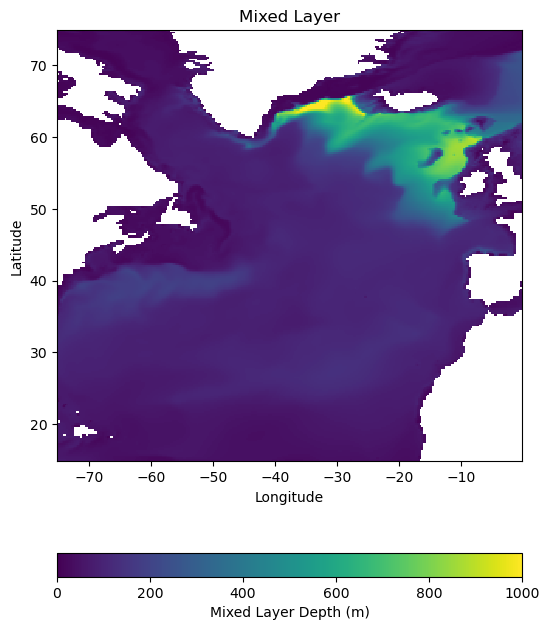

In [6]:
# create a figure object
fig = plt.figure(figsize=(6,8))

# plot the temperature
plt.pcolormesh(longitude_sliced, latitude_sliced, MXL_sliced, vmin=0, vmax=1000, cmap="viridis")
plt.colorbar(orientation = 'horizontal', label = 'Mixed Layer Depth (m)')

# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mixed Layer')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [7]:
def plot_panel(year,month,day):
    # fill in your function here
    file_name = 'MXLDEPTH_' + str(year) + '{:02d}'.format(month) + '{:02d}'.format(day) + '.nc'
    
    mxl_path = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','MXLDEPTH.nc',file_name)

    ds = xr.open_dataset(mxl_path,decode_times=False)
    latitude = np.array(ds['LATITUDE_T'][:])
    longitude = np.array(ds['LONGITUDE_T'][:])
    MXL = np.array(ds['MXLDEPTH'][:])
    ds.close()

    frames_directory = 'C:\\Users\\azure\\Documents\\CS185\\homework_3\\frames'
    file_path = os.path.join(frames_directory, 'MXLDEPTH' + '{:02d}'.format(month) + '{:02d}'.format(day) + '.png')
    file_list.append(file_path)

    MXL_sliced = MXL[0, min_col:max_col, min_row:max_row]
    longitude_sliced = longitude[min_row:max_row + 1]
    latitude_sliced = latitude[min_col:max_col + 1]

    
    # create a figure object
    fig = plt.figure(figsize=(6,8))

    # plot the temperature
    plt.pcolormesh(longitude_sliced, latitude_sliced, MXL_sliced, vmin= 0, vmax=1000, cmap="viridis")
    plt.colorbar(orientation = 'horizontal', label = 'Mixed Layer Depth (m)')

    # format the axes
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Mixed Layer          Month: ' '{:02d}'.format(month))
    plt.savefig(file_path)
    plt.close(fig)

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [8]:
# loop through the data and make a plot for each day
file_list = []
year = 2013

for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        plot_panel(year,month,day)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [9]:
# set the frames per second
fps = 24

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

# write the video to a file
clip.write_videofile('MXL DEPTH in North Atlantic.mp4')

Moviepy - Building video MXL DEPTH in North Atlantic.mp4.
Moviepy - Writing video MXL DEPTH in North Atlantic.mp4



Moviepy - Done !
Moviepy - video ready MXL DEPTH in North Atlantic.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: In the movie, when summer arrives, the mixed layer disappears almost entirely, and reappears when winter arrives. The mixed layer is a homogenous layer of water that has constant salinity and temperature throughout. In the summer, the heat from the Sun prevents the ocean from mixing together due to the large temperature gradient. In winter, the water is able to mix well with the colder, deeper waters, producing a large region of mixed layers.